# Reshaping data for model
### In this file, we will take the data that has been gathered and harmonized and we will fit it, create scenarios, and save it as a structured array for the model. Since we would like to keep the flexibility with excel, we will also save it in an ODYM compatible format and create a file that can do the reverse: if teh excel file is eddited, so is the array. This will be a separate script

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from seaborn.palettes import color_palette
# import xlrd
import pylab
from copy import deepcopy
import logging as log
import xlwt
import tqdm
import math
from scipy.stats import norm
from tqdm import tqdm
from scipy.optimize import curve_fit
import matplotlib
from matplotlib import rc
from logistic import logistic as logistic
mpl_logger = log.getLogger("matplotlib")
mpl_logger.setLevel(log.WARNING)  

### Importing datasheet with targets to make fits

In [2]:
# Importing data
# df = pd.read_excel(data_path+'/V2G_scenarios.xlsx')
df = pd.read_excel('V2G_scenarios.xls')
# df.head()

### Creating logistic fits

In [3]:
# Create logistic fits
Nv = 5 # number of scenarios
t = np.arange(1950,2051)
Nt = len(t)
fit = np.zeros((Nv, Nt))
# start counter
i = 0
for s in df['Scenario'].unique():
    popt, pcov = curve_fit(logistic, df.loc[(df['Scenario']==s), 'Time'].values, df.loc[(df['Scenario']==s), 'value'].values, bounds=([2020, 0., 0, 0], [2050, 10, 1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
    fit[i,:] = logistic(t, *popt)
    # increment counter
    i = i+1

C:\Users\lauinger\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


### Plotting results

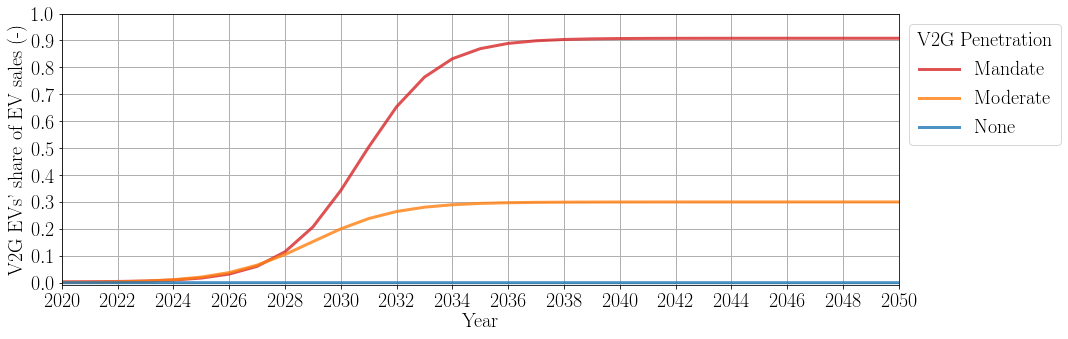

In [9]:
# layout
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
fig = plt.figure(figsize=[15, 5], facecolor ='white')
plt.rcParams.update({'font.size': 20})
transp = 0.8
# plotting
# MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
# plt.plot(t[69:], fit[0,69::], label='Low', linewidth = 3, alpha = transp)
plt.plot(t[69:], fit[3,69:], label='Mandate', linewidth = 3, alpha = transp, color = 'tab:red')
plt.plot(t[69:], fit[1,69:], label='Moderate', linewidth = 3, alpha = transp, color = 'tab:orange')
# plt.plot(t[69:], fit[2,69:],label='High', linewidth = 3, alpha = transp)
plt.plot(t[69:], fit[4,69:],label='None', linewidth = 3, alpha = transp, color = 'tab:blue')
# plt.plot(df.loc[(df['Scenario']=='Low') & (df['Drive_train']=='BEV'), 'Time'].values, df.loc[(df['Scenario']=='Low') & (df['Drive_train']=='BEV'), 'value'].values, 'x', label='Low data')
# plt.plot(df.loc[(df['Scenario']=='Moderate') & (df['Drive_train']=='BEV'), 'Time'].values, df.loc[(df['Scenario']=='Moderate') & (df['Drive_train']=='BEV'), 'value'].values,'x',label='Moderate data')
# plt.plot(df.loc[(df['Scenario']=='High') & (df['Drive_train']=='BEV'), 'Time'].values, df.loc[(df['Scenario']=='High') & (df['Drive_train']=='BEV'), 'value'].values,'x',label='High data')
plt.legend(loc = 'upper left', bbox_to_anchor=(1,1), title = 'V2G Penetration')
plt.ylabel('V2G EVs\' share of EV sales (-)')
# ax.set_title('V2G ratio scenarios'.format(s))
plt.xlabel('Year')
plt.grid(linewidth = 1)
plt.xlim((2020, 2050))
plt.xticks(np.arange(2020, 2051, 2))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim((-0.01, 1))
plt.savefig('V2G_penetration.pdf', bbox_inches = 'tight')
plt.savefig('V2G_penetration.png', bbox_inches = 'tight')

## Preparing V2G ratio
Since the aim of V2G is to make use of oversized and underused LIBs, we assume that only BEVs participate in the V2G market. 
We define scenarios for the V2G penetration which apply only to BEVs and that change over time. 

In [ ]:
V2GArray = np.zeros((Nv,Ng,Nt))

In [ ]:
# Defining empty DataFrame with the desired dimensions
lp0, lp1, lp2 = pd.core.reshape.util.cartesian_product([IndexTable.Classification[IndexTable.index.get_loc('V2G_Scenarios')].Items,IndexTable.Classification[IndexTable.index.get_loc('Drive_train')].Items, IndexTable.Classification[IndexTable.index.get_loc('Time')].Items])
data = pd.DataFrame(dict(Scenario= lp0, Drive_train=lp1, Time=lp2))

### Add values to dataframe and fill with zeroes if NaN

In [ ]:
data.loc[(data['Drive_train']=='BEV') & (data['Scenario']=='Low'), 'value'] = fit[0,1,:]
data.loc[(data['Drive_train']=='BEV') & (data['Scenario']=='Moderate'), 'value'] = fit[1,1,:]
data.loc[(data['Drive_train']=='BEV') & (data['Scenario']=='High'), 'value'] = fit[2,1,:]
data.loc[(data['Drive_train']=='BEV') & (data['Scenario']=='V2G mandate'), 'value'] = fit[3,1,:]
data.loc[(data['Drive_train']=='BEV') & (data['Scenario']=='No V2G'), 'value'] = fit[4,1,:]

In [ ]:
data.fillna(0, inplace=True)

In [ ]:
# define results path
results_path = os.path.join(os.getcwd(), 'data', 'scenario_data')

In [ ]:
# Save as excel for overview
data.to_excel(results_path+'/V2G_ratio.xlsx')

In [ ]:
data.loc[data['Drive_train']=='BEV']

In [ ]:
for m in range(0,len(data['Time'])):
    ScenarioPosition = IndexTable.Classification[IndexTable.index.get_loc('V2G_Scenarios')].Items.index(data['Scenario'].iloc[m])
    DriveTrainPosition = IndexTable.Classification[IndexTable.index.get_loc('Drive_train')].Items.index(data['Drive_train'].iloc[m])
    TimePosition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(data['Time'].iloc[m])
    V2GArray[ScenarioPosition, DriveTrainPosition, TimePosition] = data['value'].iloc[m]

In [ ]:
np.save(results_path+'/V2G_ratio', V2GArray, allow_pickle=True)